In [46]:
# Abstention and Label Cleaning
from pprint import pprint
import matplotlib.pyplot as plt

import sys

sys.path.append("..")

from part2.logprobs import get_logprobs_cached
from part3.data_loader import load_language_data
from part3.metrics import predictive_entropy, log_margin
import seaborn as sns
import pandas as pd


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading and preparing data...
Training data shape: (1000,)
Test data shape: (0,)
Sample training data:
46730                     Hab für den Preis mehr erwartet.
48393       Письмо в письменном виде убийцы , друзья мои !
41416    जापानियों ने रैंकिंग दृश ् य और स ् थानों के प...
34506    وفي عام 1853 , كان القصد من قصر دولما - bahce ...
43725    Các nhà chức trách y tế anh , trong 1995 nguyê...
Name: text, dtype: object
Sample training labels:
46730    de
48393    ru
41416    hi
34506    ar
43725    vi
Name: labels, dtype: object
(1000,)
Getting metrics ... 


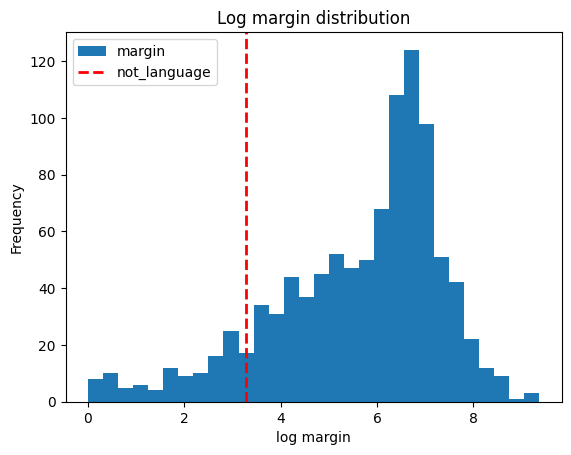

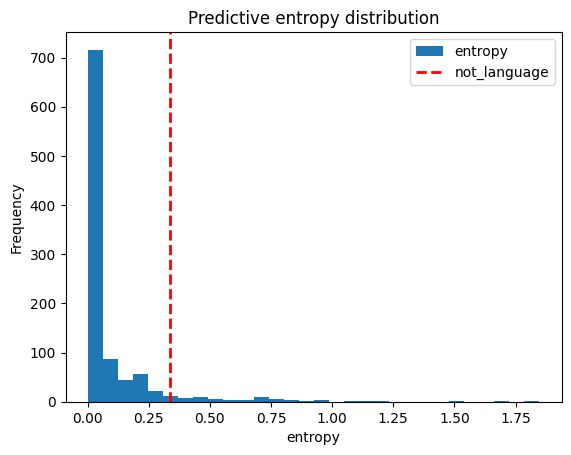

In [47]:


def run_prompts(inputs, prompt_template, **kwargs):
    all_logprobs = []
    if isinstance(inputs, str):
        inputs = [inputs]

    for x in inputs:
        prompt = prompt_template.format(text=x)
        logprobs = get_logprobs_cached(prompt, **kwargs).logprobs
        all_logprobs.append(logprobs)

    return all_logprobs


def metrics_for(inputs, prompt_template, **kwargs):

    # metric_fns = [predictive_entropy, log_margin]
    if isinstance(inputs, str):
        inputs = [inputs]
    
    logprobs = run_prompts(inputs, prompt_template, **kwargs)
    rows = []
    for lp in logprobs:
        entropy = predictive_entropy(lp)
        margin = log_margin(lp)

        rows.append({
            'entropy': entropy, 
            'margin': margin,
            'log_probs': lp
        })
    df = pd.DataFrame(rows)
    df['inputs'] = inputs
    return df


def run_experiment(texts, labels, kwargs):

    # print(X_train)

    # Create a profile of the log probs
    prompt_template = """Given the text below, determine the single most appropriate ISO 639-1 language code.
    Answer with the code only.

    Text: {text}

    Language code:"""

    not_language = "0103183901849103"
    # not_language = "01001000 01100101 01101100 01101100 01101111 00101100 00100000 01010111 01101111 01110010 01101100 01100100 00100001"

    inputs = [not_language] + texts.to_list()

    print("Getting metrics ... ")
    df = metrics_for(inputs, prompt_template, **kwargs)
    df['lang'] = [None] + labels.to_list()
    df['is_language'] = True
    df.loc[0, 'is_language'] = False

    not_lang_row = df.loc[~df["is_language"]].iloc[0]

    not_lang_margin = not_lang_row["margin"]
    not_lang_entropy = not_lang_row["entropy"]

    _, ax = plt.subplots()

    df.query("is_language")["margin"].plot.hist(ax=ax, bins=30)
    ax.axvline(not_lang_margin, linestyle="--", linewidth=2, label="not_language", color='r')

    ax.set_title("Log margin distribution")
    ax.set_xlabel("log margin")
    ax.legend()

    plt.show()

    _, ax = plt.subplots()

    df.query("is_language")["entropy"].plot.hist(ax=ax, bins=30)
    ax.axvline(not_lang_entropy, linestyle="--", linewidth=2, label="not_language", color="r")

    ax.set_title("Predictive entropy distribution")
    ax.set_xlabel("entropy")
    ax.legend()

    plt.show()

    return df


X_train, y_train, _, _ = load_language_data(train_size=1000, test_size=0)
print(X_train.shape)
df = run_experiment(X_train, y_train, kwargs = {"model_id": 'llama3:8b', "provider": 'ollama', "invert_log": False, "top_logprobs": 20})

In [48]:
df

,entropy,margin,log_probs,inputs,lang,is_language
0,0.339180,3.289841,"{'en': -0.07577058672904968, 'zh': -3.36561131...",0103183901849103,None,False
1,0.020658,5.903009,"{'de': -0.0028976586181670427, 'DE': -5.905907...",Hab für den Preis mehr erwartet.,de,True
2,0.053272,4.864649,"{'ru': -0.008620364591479301, 'RU': -4.8732690...","Письмо в письменном виде убийцы , друзья мои !",ru,True
3,0.013602,7.374560,"{'ja': -0.001530420035123825, 'JA': -7.3760900...",जापानियों ने रैंकिंग दृश ् य और स ् थानों के प...,hi,True
4,0.079139,4.476154,"{'ar': -0.013378063216805458, 'tr': -4.4895324...","وفي عام 1853 , كان القصد من قصر دولما - bahce ...",ar,True
...,...,...,...,...,...,...
996,0.017347,6.789505,"{'ar': -0.0021252306178212166, 'arb': -6.79163...","وبالمثل , يتم توفير النقل الجوي بموجب العقد , ...",ar,True
997,0.008880,7.055460,"{'el': -0.0010418430902063847, 'EL': -7.056501...",Τι θα γίνει με τους άλλους ;,el,True
998,0.009956,7.183597,"{'ja': -0.0011325654340907931, 'JA': -7.184730...",５インチなので仕方が無いのですが画面が小さい。スマホを見てる感じで目が疲れます。,ja,True
999,0.075777,4.377605,"{'ru': -0.013500286266207695, 'RU': -4.3911056...",Высоко на холмах 27 км ( 17 миль ) к югу от мо...,ru,True


In [49]:
# Higher entropy -> more uncertainty
df.sort_values(by='entropy', ascending=False).head(5)[['lang', 'inputs', 'entropy']].style.hide(axis='index')

lang,inputs,entropy
sw,"-- yako humbly ,",1.846331
hi,"स ् कॉटलैंड के संग ् रहालय के लिए टिकट , शाही संग ् रहालय के मुख ् य संग ् रह के लिए भी प ् रवेश करने की अनुमति देते हैं , जो स ् कॉटलैंड को स ् कॉटलैंड में लाने के संग ् रहपाल का उद ् देश ् य पूरा करते हैं , और दुनिया को स ् कॉटलैंड की दुनिया में .",1.822558
tr,Kokteyl mi uh ne,1.672582
sw,Should nini ?,1.492497
sw,Kichwa sahihi zaidi kwa ajili ya jengo ni kirk ya juu ya edinburgh .,1.182857


In [50]:
df.sort_values(by='margin', ascending=True).head(5)

,entropy,margin,log_probs,inputs,lang,is_language
208,0.767058,0.008606,"{'tr': -0.702887237071991, 'fi': -0.7114931941...",Lsc-finanse edilen yasal hizmetler için uygun ...,tr,True
381,1.171807,0.019747,"{'bg': -0.9409418106079102, 'mk': -0.960688591...",""" ла cetellana "" и "" пасео de recoletos "" са н...",bg,True
151,0.964128,0.033989,"{'ru': -0.7430660128593445, 'bg': -0.777054965...","разнообразие от теми са пространство , здраве ...",bg,True
672,0.762478,0.114721,"{'en': -0.6491408348083496, 'zh': -0.763862133...","this its headphones its really good, my nephew...",en,True
530,0.810373,0.138481,"{'ne': -0.6496648192405701, 'hi': -0.788145959...",सब कुछ याद है ...,hi,True


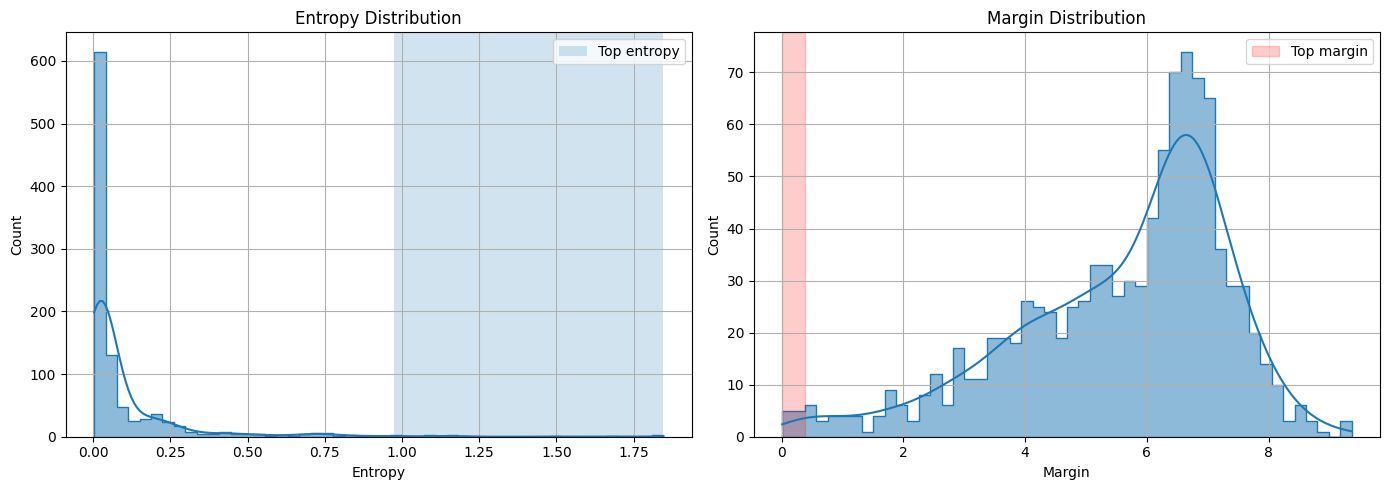

In [53]:
N = 10  # number of top points to highlight

# Identify top points
top_entropy = df.sort_values(by="entropy", ascending=False).head(N)
top_margin = df.sort_values(by="margin", ascending=True).head(N)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Precompute span ranges
entropy_span = (
    top_entropy["entropy"].min(),
    top_entropy["entropy"].max(),
)
# margin_span_entropy_axis = (
#     top_margin["entropy"].min(),
#     top_margin["entropy"].max(),
# )

margin_span = (
    top_margin["margin"].min(),
    top_margin["margin"].max(),
)
# entropy_span_margin_axis = (
#     top_entropy["margin"].min(),
#     top_entropy["margin"].max(),
# )

# --- Entropy histogram ---
sns.histplot(df["entropy"], bins=50, element="step", alpha=0.5, kde=True, ax=axes[0])

# Rectangle regions
axes[0].axvspan(
    entropy_span[0],
    entropy_span[1],
    alpha=0.2,
    label="Top entropy",
)

# axes[0].axvspan(
#     margin_span_entropy_axis[0],
#     margin_span_entropy_axis[1],
#     alpha=0.2,
#     label="Top margin",
# )

axes[0].set_title("Entropy Distribution")
axes[0].set_xlabel("Entropy")
axes[0].set_ylabel("Count")
axes[0].grid(True)

# --- Margin histogram ---
sns.histplot(df["margin"], bins=50, element="step", alpha=0.5, kde=True, ax=axes[1])

# Rectangle regions
axes[1].axvspan(
    margin_span[0],
    margin_span[1],
    alpha=0.2,
    color='red',
    label="Top margin",
)

# axes[1].axvspan(
#     entropy_span_margin_axis[0],
#     entropy_span_margin_axis[1],
#     alpha=0.2,
#     color='red',
#     label="Top entropy",
# )

axes[1].set_title("Margin Distribution")
axes[1].set_xlabel("Margin")
axes[1].set_ylabel("Count")
axes[1].grid(True)

# Add legends (avoid duplicate labels)
for ax in axes:
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()


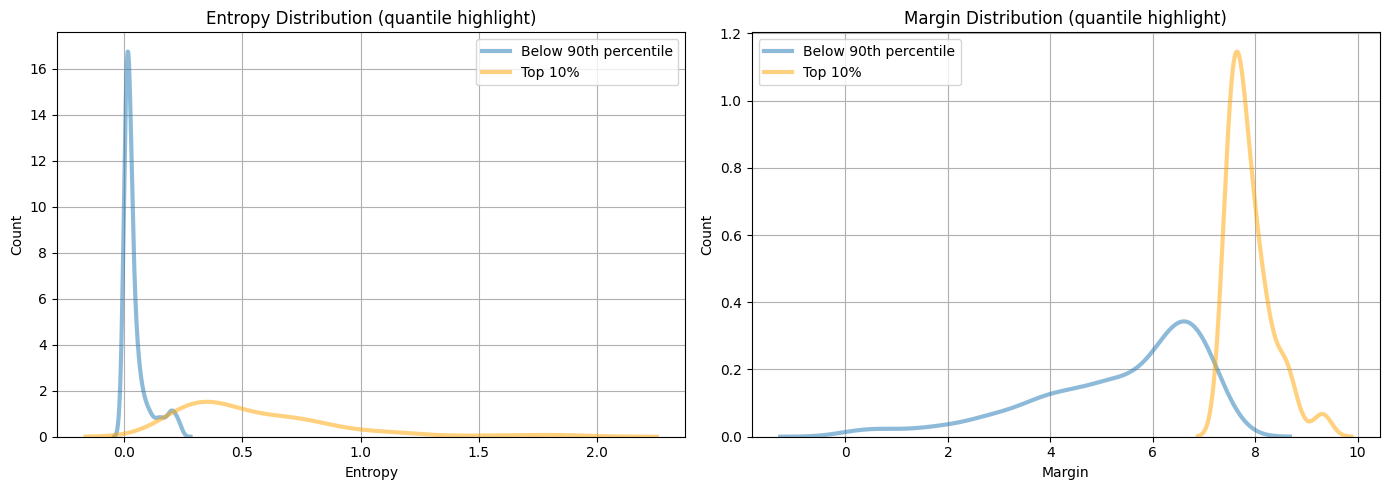

In [14]:

# Configuration
quantile_cutoff = 0.9  # top 5%
metrics = ["entropy", "margin"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, metric in zip(axes, metrics):
    # Compute cutoff
    threshold = df[metric].quantile(quantile_cutoff)
    
    # Split core vs top quantile
    core = df[df[metric] < threshold]
    top = df[df[metric] >= threshold]
    
    # Plot core histogram + KDE
    # sns.histplot(
    #     core[metric], 
    #     bins=50, 
    #     stat='percent', 
    #     element="step", 
    #     alpha=0.5, 
    #     # kde=True, 
    #     ax=ax, 
    #     label=f"Below {quantile_cutoff*100:.0f}th percentile"
    # )
    sns.kdeplot(core[metric], alpha=0.5, ax=ax, label=f"Below {quantile_cutoff*100:.0f}th percentile", linewidth=3)
    
    # Plot top quantile separately
    # sns.histplot(top[metric], bins=5, stat='percent', element="step", alpha=0.5, kde=False, ax=ax, color="orange", label=f"Top {100 - quantile_cutoff*100:.0f}%")
    sns.kdeplot(top[metric], alpha=0.5, ax=ax, color="orange", label=f"Top {100 - quantile_cutoff*100:.0f}%", linewidth=3)
    
    ax.set_title(f"{metric.capitalize()} Distribution (quantile highlight)")
    ax.set_xlabel(metric.capitalize())
    ax.set_ylabel("Count")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


Getting metrics ... 


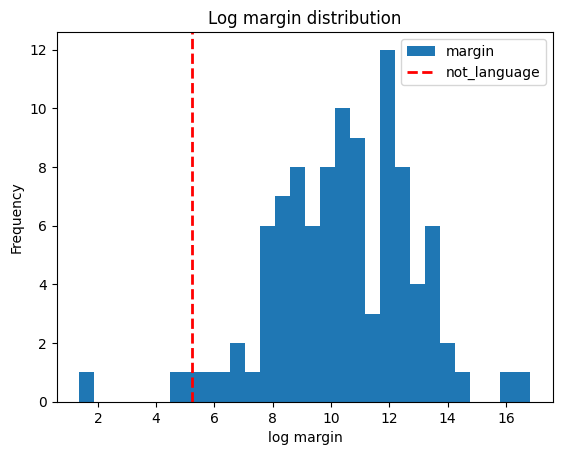

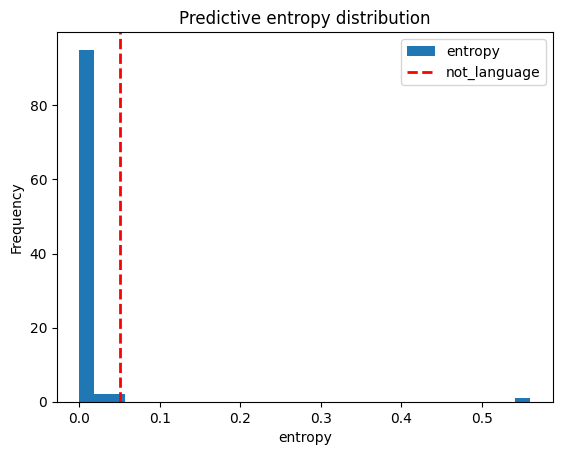

In [15]:
df = run_experiment(X_train[:100], y_train[:100], kwargs = {"model_id": 'gemini-2.5-flash-lite', "provider": 'gemini', "invert_log": False, "top_logprobs": 20})

In [16]:
df.sort_values(by='entropy', ascending=False).head(5)

,entropy,margin,log_probs,inputs,lang,is_language
3,0.560652,1.366776,"{'ja': -0.23522674, 'hi': -1.6020023, '""': -5....",जापानियों ने रैंकिंग दृश ् य और स ् थानों के प...,hi,True
87,0.054788,4.914870,"{'tr': -0.008655886, 'az': -4.9235263, 'tk': -...","Keşmir , hem hindistan hem de Pakistan arasınd...",tr,True
0,0.050931,5.231850,"{'und': -0.007421305, 'en': -5.239271, 'un': -...",0103183901849103,None,False
55,0.039706,5.449919,"{'ru': -0.0057685566, 'bg': -5.4556875, '""': -...",Район,ru,True
20,0.034360,6.180376,"{'sw': -0.004263241, 'rw': -6.1846395, 'zu': -...","Ofisi ya new york ya slate , ambapo jacob hung...",sw,True


In [17]:
df.sort_values(by='entropy', ascending=False).iloc[0]['inputs']

'जापानियों ने रैंकिंग दृश ् य और स ् थानों के पारंपरिक चीनी अभ ् यास को अपनाया है और korakian आधिकारिक रूप से जापान के तीन बड ़ े बाग ़ हैं .'

In [18]:
def run_experiment_distribution_shift(df1, df2, allowed_iso_codes_str, kwargs):

    # print(X_train)

    # Create a profile of the log probs
    prompt_template = """Given the text below, determine the single most appropriate ISO 639-1 language code.
    Answer with the code only.

    Text: {text}

    Allowed ISO 639-3 codes: {allowed_iso_codes_str}

    Language code:"""


    _, ax = plt.subplots()

    df.query("is_language")["margin"].plot.hist(ax=ax, bins=30)
    ax.axvline(not_lang_margin, linestyle="--", linewidth=2, label="not_language", color='r')

    ax.set_title("Log margin distribution")
    ax.set_xlabel("log margin")
    ax.legend()

    plt.show()

    _, ax = plt.subplots()

    df.query("is_language")["entropy"].plot.hist(ax=ax, bins=30)
    ax.axvline(not_lang_entropy, linestyle="--", linewidth=2, label="not_language", color="r")

    ax.set_title("Predictive entropy distribution")
    ax.set_xlabel("entropy")
    ax.legend()

    plt.show()

    return df

# run_experiment_distribution_shift(df['lang'])

X_train, y_train, _, _ = load_language_data(train_size=10000, test_size=0)

Loading and preparing data...
Training data shape: (10000,)
Test data shape: (0,)
Sample training data:
46730                     Hab für den Preis mehr erwartet.
48393       Письмо в письменном виде убийцы , друзья мои !
41416    जापानियों ने रैंकिंग दृश ् य और स ् थानों के प...
34506    وفي عام 1853 , كان القصد من قصر دولما - bahce ...
43725    Các nhà chức trách y tế anh , trong 1995 nguyê...
Name: text, dtype: object
Sample training labels:
46730    de
48393    ru
41416    hi
34506    ar
43725    vi
Name: labels, dtype: object


In [19]:
y_train[y_train.isin(['en', 'fr', 'zh'])].value_counts()

labels
en    528
fr    480
zh    477
Name: count, dtype: int64

In [55]:
# Spam, with more modern spam

from data_loader import load_spam_data

X_train, y_train, _, _ = load_spam_data(train_size=1000, test_size=0)

In [78]:
spam_df = pd.DataFrame({
    'text': X_train,
    'is_spam': y_train
})
# Hide the index when displaying the DataFrame
# spam_df.
# pd.set_option('display.max_colwidth', 180)

pd.concat([
    spam_df.query("is_spam == 'Yes'").sample(1),
    spam_df.query("is_spam == 'No'").sample(1)
]).style.hide(axis='index')
# spam_df

text,is_spam
WOW! The Boys R Back. TAKE THAT 2007 UK Tour. Win VIP Tickets & pre-book with VIP Club. Txt CLUB to 81303. Trackmarque Ltd info@vipclub4u.,Yes
"Hey babe! I saw you came online for a second and then you disappeared, what happened ?",No


In [59]:
from datasets import load_dataset

# Newer dataset
telegram_data = load_dataset('thehamkercat/telegram-spam-ham')
telegram_data

DatasetDict({
    train: Dataset({
        features: ['text_type', 'text'],
        num_rows: 20348
    })
})

In [62]:
tele_df = telegram_data['train'].to_pandas()
pd.concat([
    tele_df.query("text_type == 'ham'").sample(3),
    tele_df.query("text_type == 'spam'").sample(2)
]).style.hide(axis='index')

text_type,text
ham,power trading fyi this could be quite important for us through forming a tradinf co we could be brokering deals on behalf of mseb without letting them off the hook in this manner we could be doing short term deals and increasing despatch from dabhol or other mseb marginal units any money flowing from these sales should go into an escrow account that goes directly towards payment of dpc bills in this manner we would be increasing the payment ability of mseb regards sandeep forwarded by sandeep kohli enron development on 01 29 2001 08 45 pm k seethayya 01 29 2001 03 49 pm to wade cline enron development enron development neil cc jane wilson enron development enron development sandeep kohli enron
ham,thanks honey but still havent heard anything i will leave it a bit longer so not 2 crowd him and will try later great advice thanks hope cardiff is still there
ham,i will mute fudders for 24 hours slightest fud and i’ll mute positive chat only
spam,office space with personal terrace 12 lac onwrds regal emporia the 1st mall of noida xtn 12 assured return with bank guarantee sms in to 54999
spam,claim your free 1000 home depot gift card claim your home depot gift card a 1000 value were sure you can find a use for this gift card in your area by exclusiverewards dbdbkewi


In [24]:
spam_df['is_spam'].value_counts()

is_spam
No     873
Yes    127
Name: count, dtype: int64

In [25]:
prompt_template = """
You are a spam detector. Is the following message spam or not?

Answer with exactly one token: Yes or No.

Here are some examples of spam:

'FREE RINGTONE text FIRST to 87131 for a poly or text GET to 87131 for a true tone! Help? 0845 2814032 16 after 1st free, tones are 3x£150pw to e£nd txt stop',
 'This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.',
 'Reminder: You have not downloaded the content you have already paid for. Goto http://doit. mymoby. tv/ to collect your content.'

And here are some examples of ham:

'Squeeeeeze!! This is christmas hug.. If u lik my frndshp den hug me back.. If u get 3 u r cute:) 6 u r luvd:* 9 u r so lucky;) None? People hate u:',
"And also I've sorta blown him off a couple times recently so id rather not text him out of the blue looking for weed",
'Mmm thats better now i got a roast down me! i\x92d b better if i had a few drinks down me 2! Good indian?'

Message:
`{text}`

Answer:
"""

def metrics_for_df(df, input_col, prompt_template, kwargs):
    df = df.reset_index(drop=True)
    inputs = df[input_col].to_list()
    logprobs = run_prompts(inputs, prompt_template, **kwargs)
    rows = []
    for lp in logprobs:
        entropy = predictive_entropy(lp)
        margin = log_margin(lp)

        rows.append({
            'entropy': entropy, 
            'margin': margin,
            'log_probs': lp
        })
    df2 = pd.DataFrame(rows)
    df2['inputs'] = inputs
    df2['is_spam'] = df['is_spam']
    return df2

kwargs = {"model_id": 'llama3:8b', "provider": 'ollama', "invert_log": False, "top_logprobs": 2}
tele_df['is_spam'] = tele_df['text_type'].map({
    'ham': 'No',
    'spam': 'Yes'
})
tele_metrics_df = metrics_for_df(tele_df.sample(1000, random_state=42), 'text', prompt_template, kwargs=kwargs)
# tele_df.sample(1000, random_state=42)['is_spam'].value_counts()
tele_metrics_df['is_spam'].value_counts()

is_spam
No     715
Yes    285
Name: count, dtype: int64

In [26]:
print(tele_df['text_type'].value_counts())
tele_df['is_spam'] = tele_df['text_type'].map({
    'ham': 'No',
    'spam': 'Yes'
})
print(tele_df['is_spam'].value_counts())

text_type
ham     14337
spam     6011
Name: count, dtype: int64
is_spam
No     14337
Yes     6011
Name: count, dtype: int64


In [27]:
tele_df['text_type'].value_counts()

text_type
ham     14337
spam     6011
Name: count, dtype: int64

In [28]:
sms_metrics_df = metrics_for_df(spam_df, 'text', prompt_template, kwargs=kwargs)
sms_metrics_df['is_spam'].value_counts()

is_spam
No     873
Yes    127
Name: count, dtype: int64

(array([764.,  75.,  27.,  22.,  19.,  15.,  19.,  10.,  16.,  33.]),
 array([0.01295695, 0.08097212, 0.14898729, 0.21700247, 0.28501764,
        0.35303282, 0.42104799, 0.48906317, 0.55707834, 0.62509352,
        0.69310869]),
 <BarContainer object of 10 artists>)

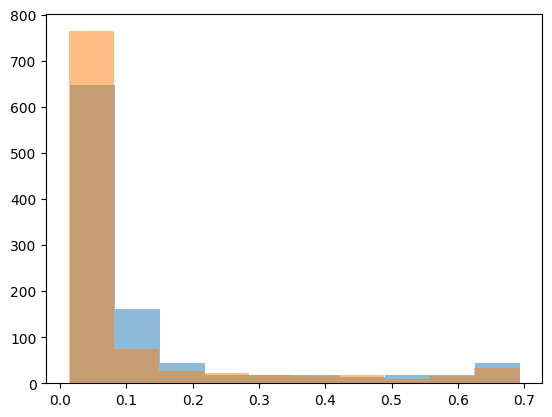

In [29]:
plt.hist(tele_metrics_df['entropy'], alpha=0.5)
plt.hist(sms_metrics_df['entropy'], alpha=0.5)
# plt.hist(tele_metrics_df['margin'])

(array([ 28.,  23.,  32.,  33.,  39.,  40., 118., 251., 361.,  75.]),
 array([0.01754761, 0.64953993, 1.28153224, 1.91352456, 2.54551688,
        3.1775092 , 3.80950152, 4.44149383, 5.07348615, 5.70547847,
        6.33747079]),
 <BarContainer object of 10 artists>)

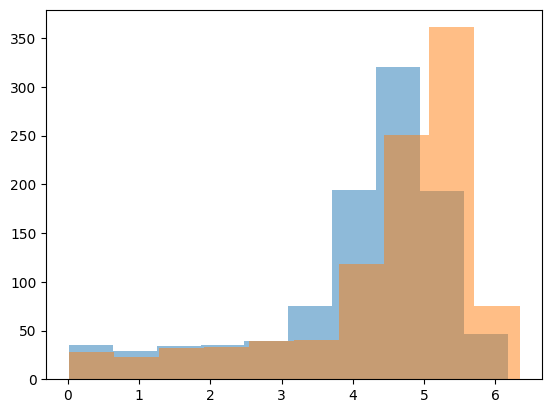

In [30]:
plt.hist(tele_metrics_df['margin'], alpha=0.5)
plt.hist(sms_metrics_df['margin'], alpha=0.5)

In [31]:
tele_metrics_df['src'] = 'telegram'
sms_metrics_df['src'] = 'sms'

eval_df = pd.concat([
    tele_metrics_df,
    sms_metrics_df
])

In [32]:
tele_metrics_df['is_spam'].value_counts()

is_spam
No     715
Yes    285
Name: count, dtype: int64

In [33]:
eval_df.groupby('src')['is_spam'].value_counts()

src       is_spam
sms       No         873
          Yes        127
telegram  No         715
          Yes        285
Name: count, dtype: int64

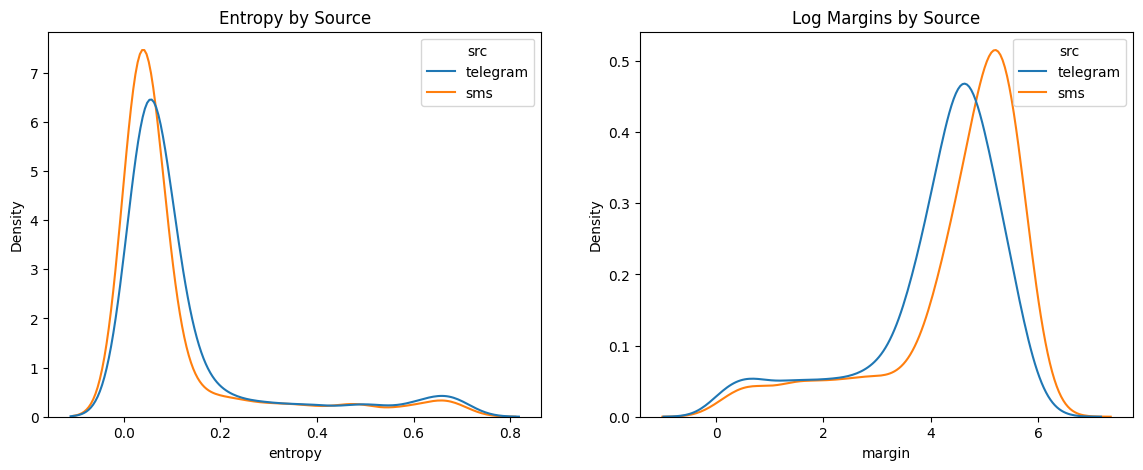

In [34]:
import seaborn as sns

fig, axes = plt.subplots(ncols=2, figsize=(14, 5), sharey=False)

sns.kdeplot(
    data=eval_df,
    x="entropy",
    hue="src",
    ax=axes[0],
    bw_adjust=1.0,
    common_norm=False,
    # clip=(
    #     eval_df["log_entropies"].quantile(0.000001),
    #     eval_df["log_entropies"].quantile(0.999999),
    # )
)
axes[0].set_title("Entropy by Source")

sns.kdeplot(
    data=eval_df,
    x="margin",
    hue="src",
    common_norm=False,
    bw_adjust=1.0,
    ax=axes[1],
    # clip=(
    #     eval_df["log_margins"].quantile(0.00001),
    #     eval_df["log_margins"].quantile(0.99999),
    # ),
    # xlim=[0, 1]
)
axes[1].set_title("Log Margins by Source");

/var/folders/b3/92n6z87s0t93y9pmdlz3_66dcd4_mv/T/ipykernel_31655/2347111712.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(title="Source")


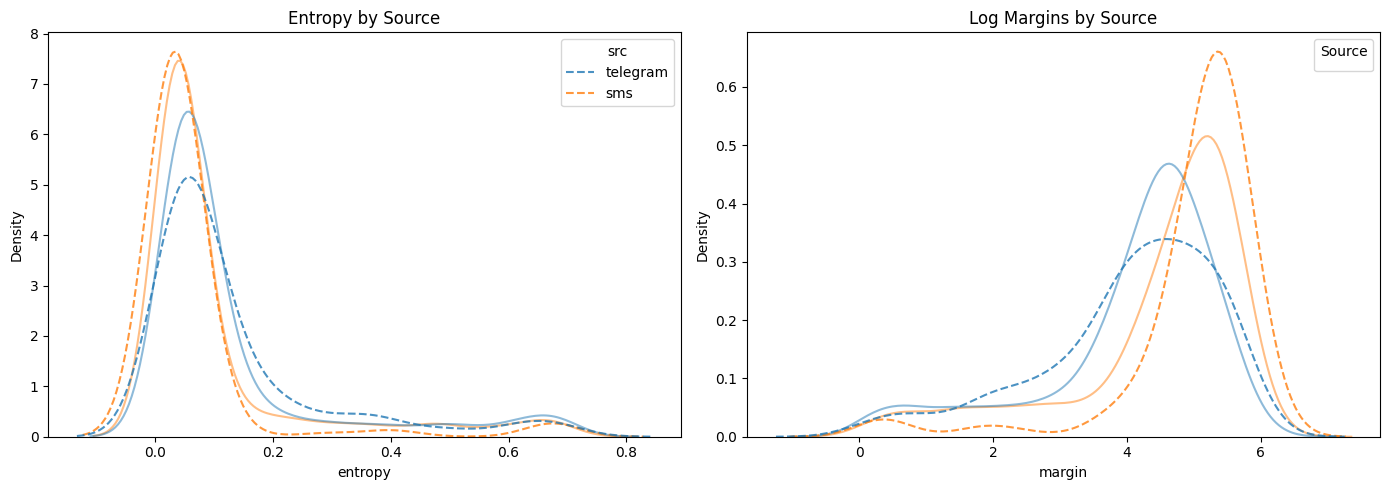

In [35]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5), sharey=False)

# --- Full distributions by source ---
sns.kdeplot(
    data=eval_df,
    x="entropy",
    hue="src",
    ax=axes[0],
    bw_adjust=1.0,
    common_norm=False,
    alpha=0.5,
)
axes[0].set_title("Entropy by Source")

sns.kdeplot(
    data=eval_df,
    x="margin",
    hue="src",
    common_norm=False,
    bw_adjust=1.0,
    ax=axes[1],
    alpha=0.5,
)
axes[1].set_title("Log Margins by Source")


# --- Spam-only overlay ---
spam_eval_df = eval_df[eval_df["is_spam"] == 'Yes']  # select spam messages

sns.kdeplot(
    data=spam_eval_df,
    x="entropy",
    hue="src",
    ax=axes[0],
    bw_adjust=1.0,
    common_norm=False,
    linestyle="--",
    alpha=0.8,
    # label="Spam Only"
)
sns.kdeplot(
    data=spam_eval_df,
    x="margin",
    hue="src",
    common_norm=False,
    bw_adjust=1.0,
    ax=axes[1],
    linestyle="--",
    alpha=0.8,
    # label="Spam Only"
)

# Optional: add mean/median markers for spam-only
# for src in spam_df["src"].unique():
#     mean_entropy = spam_df.loc[spam_df["src"] == src, "entropy"].mean()
#     mean_margin = spam_df.loc[spam_df["src"] == src, "margin"].mean()
    # axes[0].axvline(mean_entropy, color=sns.color_palette()[list(spam_df["src"].unique()).index(src)], linestyle=":", alpha=0.9)
    # axes[1].axvline(mean_margin, color=sns.color_palette()[list(spam_df["src"].unique()).index(src)], linestyle=":", alpha=0.9)

# axes[0].legend(title="Source")
axes[1].legend(title="Source")
# After all kdeplot calls

handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles[:2], labels[:2], title="Source")


plt.tight_layout()
plt.show()


<Axes: xlabel='margin', ylabel='Density'>

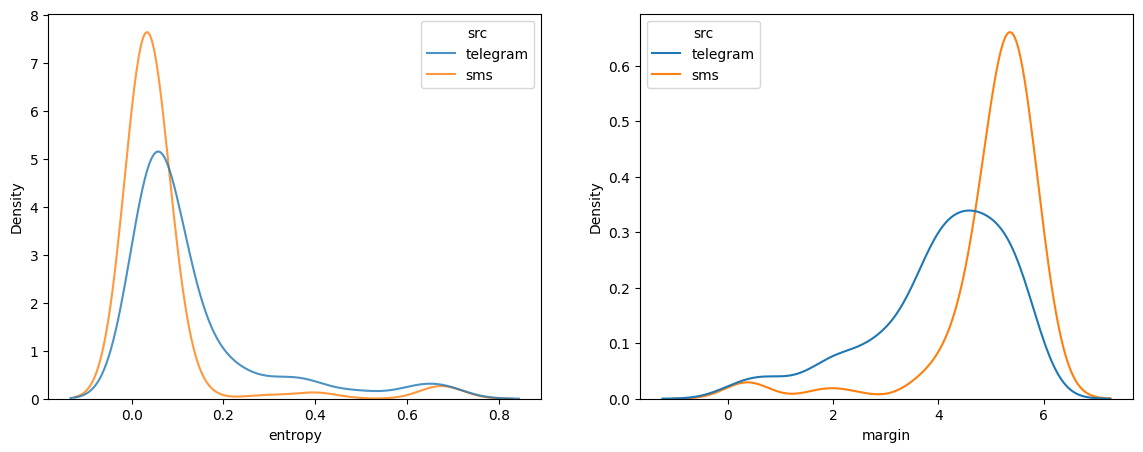

In [36]:
spam_eval_df = eval_df[eval_df["is_spam"] == 'Yes']  # select spam messages
fig, axes = plt.subplots(ncols=2, figsize=(14, 5), sharey=False)
sns.kdeplot(
    data=spam_eval_df,
    x="entropy",
    hue="src",
    ax=axes[0],
    bw_adjust=1.0,
    common_norm=False,
    # linestyle="--",
    alpha=0.8,
    # label="Spam Only"
)
sns.kdeplot(
    data=spam_eval_df,
    x="margin",
    hue="src",
    common_norm=False,
    bw_adjust=1.0,
    ax=axes[1],
    # linestyle="--",
    # alpha=0.8,
    # label="Spam Only"
)

In [37]:
# spam_df.query("is_spam == 'Yes'")['text'].head(3).to_list()
spam_df.query("is_spam == 'No'")['text'].head(3).to_list()

['Squeeeeeze!! This is christmas hug.. If u lik my frndshp den hug me back.. If u get 3 u r cute:) 6 u r luvd:* 9 u r so lucky;) None? People hate u:',
 "And also I've sorta blown him off a couple times recently so id rather not text him out of the blue looking for weed",
 'Mmm thats better now i got a roast down me! i\x92d b better if i had a few drinks down me 2! Good indian?']

In [38]:
import numpy as np
spam_eval_df['entropy_log'] = np.log(spam_eval_df['entropy'])
spam_eval_df['entropy_log'].isna().sum()

/var/folders/b3/92n6z87s0t93y9pmdlz3_66dcd4_mv/T/ipykernel_31655/3673824462.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spam_eval_df['entropy_log'] = np.log(spam_eval_df['entropy'])


np.int64(0)

In [39]:
spam_eval_df['entropy_log'].describe()

count    412.000000
mean      -2.748080
std        0.939667
min       -4.099699
25%       -3.498678
50%       -2.979144
75%       -2.288175
max       -0.366740
Name: entropy_log, dtype: float64

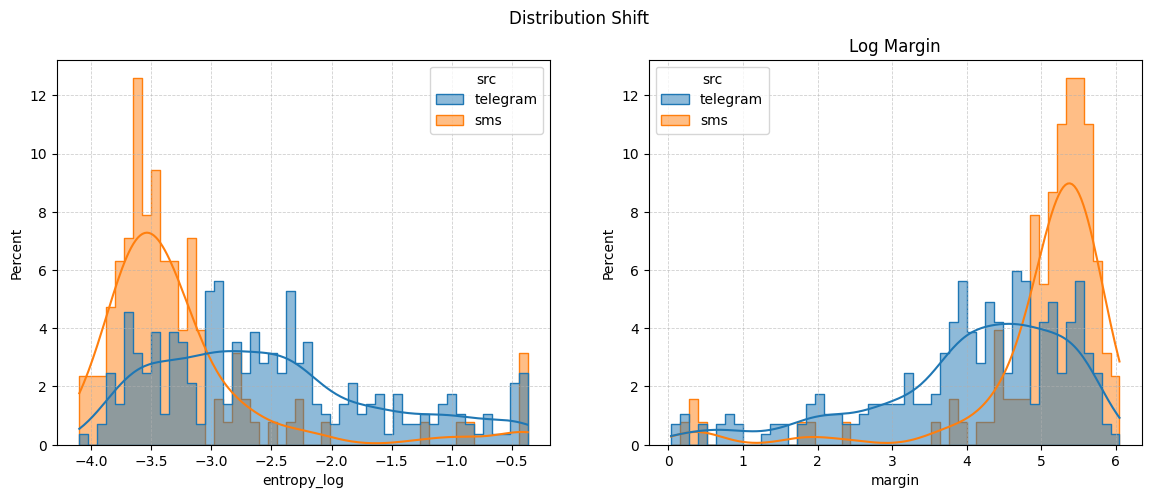

In [69]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5), sharey=False, squeeze=True)
# axes = [axes]
axes[0].grid(True)

sns.histplot(
    data=spam_eval_df,
    x="entropy_log",
    hue="src",
    ax=axes[0],
    bins=50,
    element="step",
    stat="percent",
    common_norm=False,
    alpha=0.5,
    kde=True,              # <-- add this
    kde_kws={"bw_adjust": 0.8}
)

# axes[0].set_xlim(0.0, 0.5)
# axes[0].set_title("Entropy")

sns.histplot(
    data=spam_eval_df,
    x="margin",
    hue="src",
    ax=axes[1],
    bins=50,
    element="step",
    stat="percent",
    common_norm=False,
    alpha=0.5,
    kde=True,              # <-- add this
    kde_kws={"bw_adjust": 0.8,}
)
axes[1].set_title("Log Margin")
for ax in axes:
    ax.grid(
        True,
        which="major",
        axis="both",
        linestyle="--",
        linewidth=0.6,
        alpha=0.6
    )

plt.suptitle("Distribution Shift ");


Text(0.5, 1.0, 'Log Margin Distributions')

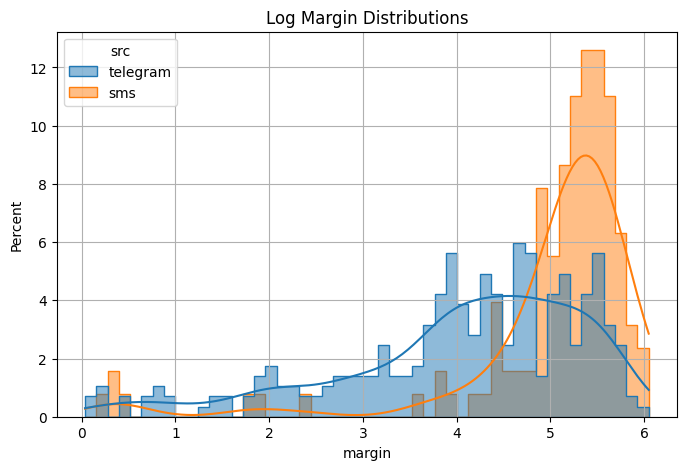

In [74]:
fig, axes = plt.subplots(ncols=1, figsize=(8, 5), sharey=False)
axes = [axes]
axes[0].grid(True)
# sns.histplot(
#     data=spam_eval_df,
#     x="entropy_log",
#     hue="src",
#     ax=axes[0],
#     bins=50,
#     element="step",
#     stat="percent",
#     common_norm=False,
#     alpha=0.5,
#     kde=True,              # <-- add this
#     kde_kws={"bw_adjust": 0.8}
# )

# axes[0].set_xlim(0.0, 0.5)
# axes[0].set_title("Entropy")

sns.histplot(
    data=spam_eval_df,
    x="margin",
    hue="src",
    ax=axes[0],
    bins=50,
    element="step",
    stat="percent",
    common_norm=False,
    alpha=0.5,
    kde=True,              # <-- add this
    kde_kws={"bw_adjust": 0.8,}
)
axes[0].set_title("Log Margin Distributions")
# for ax in axes:
#     ax.grid(
#         True,
#         which="major",
#         axis="both",
#         linestyle="--",
#         linewidth=0.6,
#         alpha=0.6
#     )

# plt.suptitle("Distribution Shift ");
